# Bayesian Hidden Markov Models

This tutorial illustrates training Bayesian Hidden Markov Models (HMM) using *Turing*. The main goals are learning the transition matrix, emission parameter, and hidden states.

First, we present a very simple HMM model, followed by a model to detect whether someone is flipping a fair coin. Let's load our libraries first.

In [231]:
# Load libraries.
using Turing, Plots, Random

# Set a random seed and use the forward_diff AD mode.
Random.seed!(1234);
Turing.setadbackend(:forward_diff);

## Simple State Detection

In our first example, we'll use a case where it is exceptionally easy to detect whether 

In [180]:
y = [ 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0 ];
N = length(y);  K = 3;

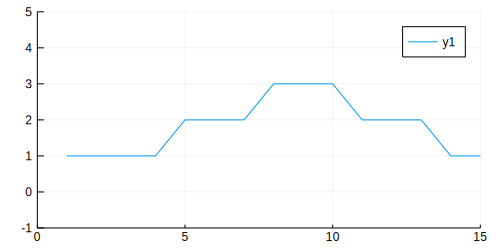

In [181]:
plot(y, xlim = (0,15), ylim = (-1,5), size = (500, 250))

In [247]:
# Turing model definition.
@model BayesHmm(y) = begin
    # Declare a TArray with a length of N.
    s = tzeros(Int, N)
    m = Vector{Real}(undef, K)
    T = Vector{Vector{Real}}(undef, K)
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.01)
    end
    
    # Draw from a distribution for each element in s.
    s[1] ~ Categorical(K)
    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
    return(s, m)
end;

In [250]:
g = Gibbs(100, HMC(2, 0.001, 5, :m, :T), PG(20, 1, :s))
c = sample(BayesHmm(y), g);

┌ Info:  Assume - `T` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `m` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `s` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Observe - `y` is an observation
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:153
[Gibbs] Sampling...100% Time: 0:00:10
┌ Info: [Gibbs] Finished with
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:163
┌ Info:   Running time    = 9.739175402999994;
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:164


In [251]:
# Import StatsPlots for animating purposes.
using StatPlots

# Iterate through the MCMC samples.
Ns = 1:100

# Extract our m and s parameters from the chain.
m_set = c[:m]
s_set = c[:s]

# Make an animation.
animation = @animate for (i, N) in enumerate(Ns)
    m = m_set[N]; s = s_set[N];
    p = plot(y, c = :red,
        size = (500, 250), 
        xlabel = "Time", 
        ylabel = "State", 
        legend = legend = :topright, label = "True data",
        xlim = (0,15),
        ylim = (-1,5)); 
    plot!(p, m[s], c = :blue, label = "Sample $N")
    end every 1;

# Show the animation.
gif(animation, "tmp1.gif", fps = 30)

┌ Info: Saved animation to 
│   fn = /home/cameron/code/TuringTutorials/tmp1.gif
└ @ Plots /home/cameron/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/home/cameron/code/TuringTutorials/tmp1.gif")

![animation](https://user-images.githubusercontent.com/3279477/46320517-b0854f80-c5d6-11e8-89f5-693e11bee169.gif)

# A Practical Example

If you prefer to think in terms of an applied case, we implement here a toy example to determine the fairness of a coin.

Suppose you play a coin flipping game with your friend, Jane. Jane's a bit of a cheater, and she alternates between using a **fair coin** (where the proabability of heads is 0.5) and a **loaded coin** (where the probability of a heads is 0.75). 

The question is, based on a series of coin flips, can you predict whether or not your friend is using a fair coin?

In [8]:
using Turing, Distributions

In [9]:
# True probability of heads with fair and unfair coins.
p_fair = 0.5;
p_unfair = 0.75;

# Set up Bernoulli distributions using the above probabilities.
fair = Bernoulli(p_fair);
unfair = Bernoulli(p_unfair);

In [10]:
# This is Jane's transition matrix.
transition_mat = [Bernoulli(0.80);  # Fair state
                  Bernoulli(0.40)]; # Unfair state

The above is equivalent to the following transition matrix:

$$
   T=
  \left[ {\begin{array}{cc}
   0.80 & 0.20 \\
   0.60 & 0.40 \\
  \end{array} } \right]
$$

We want our model to learn this matrix.

In [11]:
num_flips = 1000

state_fair = true
flips = []
states = []
for i in 1:num_flips
    push!(states, state_fair)
    if state_fair
        push!(flips, rand(fair))
        state_fair = Bool(rand(transition_mat[1]))
    else
        push!(flips, rand(unfair))
        state_fair = Bool(rand(transition_mat[2]))
    end
end

cum_flips = [flips[1]]

for i in 2:length(flips)
    change = flips[i-1] == 1 ? 1 : -1
    push!(cum_flips, cum_flips[i-1] + change)
end

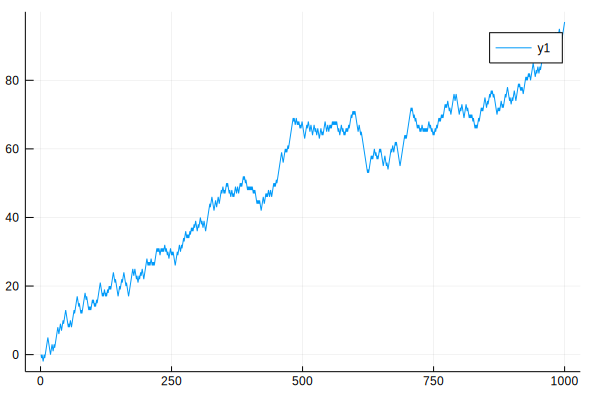

In [12]:
plot(cum_flips)

In [252]:
# Turing model definition.
@model BayesHmmCoins(y, K) = begin
    s = tzeros(Int, N)
    m = Vector{Real}(undef, K)
    T = Vector{Vector{Real}}(undef, K)
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i-1, 0.01)
    end
    s[1] ~ Categorical(ones(Float64, K)/K)
    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.4)
    end
    return(s, m)
end

BayesHmmCoins (generic function with 3 methods)

In [256]:
g = Gibbs(500, HMC(1, 0.001, 2, :m, :T), PG(20, 1, :s))
c = sample(BayesHmmCoins(y, 2), g);

┌ Info:  Assume - `T` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `m` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Assume - `s` is a parameter
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:165
┌ Info:  Observe - `y` is an observation
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/core/compiler.jl:153
[Gibbs] Sampling...100% Time: 0:00:39
┌ Info: [Gibbs] Finished with
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:163
┌ Info:   Running time    = 38.679010849;
└ @ Turing /home/cameron/.julia/packages/Turing/YnwiD/src/samplers/gibbs.jl:164


In [257]:
c[:T][end]

2-element Array{Any,1}:
 [0.844267, 0.155733]
 [0.8817, 0.1183]    